# Segmentation CNN

Here we are training a CNN to recognize if a letter is in the center of a 32x32 image. This will be used to locate letters in multi char CAPTCHAs

We have a dataset of 32x32 captcha images with one char, labeled if the char is in the middle or not. 

x : (468,000, 32, 32, 3)
y : (468,000, )  0 for uncentered, 1 otherwise

First we will preprocess the data. Our images are black and white, so we will colapse down to 1 color chanel. We will also normalize, shuffle, and make trainging splits

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Automatically reload your external source code
%load_ext autoreload
%autoreload 2

In [2]:
x = np.load('data/x_single.npy')
y = np.load('data/y_single_pos.npy')

print(f"x shape: {x.shape}")
print(f'y shape: {y.shape}')

x shape: (93600, 32, 32, 3)
y shape: (93600,)


In [3]:
#Converting to greyscale
x = np.mean(x, axis=3)
print(x.shape)

(93600, 32, 32)


In [4]:
#Normalizing
x /= 256
print(f"max x : {np.max(x)}")
print(f"min y : {np.min(x)}")

max x : 0.99609375
min y : 0.0


In [5]:
#Shuffling
print("These should be different")
print(x[0,0,:])
idx = np.arange(x.shape[0])
np.random.shuffle(idx)
x = x[idx, :, :]
y = y[idx]
print(x[0,0,:])
print(x.shape)
print(y.shape)



These should be different
[0.84765625 0.87109375 0.91015625 0.9296875  0.92578125 0.8515625
 0.81640625 0.8046875  0.90625    0.98828125 0.98046875 0.9609375
 0.9296875  0.9296875  0.91796875 0.8515625  0.86328125 0.9609375
 0.9140625  0.85546875 0.91015625 0.94921875 0.9609375  0.96484375
 0.95703125 0.90625    0.875      0.8828125  0.8984375  0.91796875
 0.8515625  0.80859375]
[0.7890625  0.734375   0.6953125  0.66015625 0.71875    0.7734375
 0.7734375  0.70703125 0.640625   0.6484375  0.66796875 0.65625
 0.61328125 0.56640625 0.5625     0.56640625 0.60546875 0.76171875
 0.91796875 0.9296875  0.87890625 0.84375    0.8671875  0.89453125
 0.88671875 0.84765625 0.8125     0.74609375 0.6796875  0.65234375
 0.66796875 0.6796875 ]
(93600, 32, 32)
(93600,)


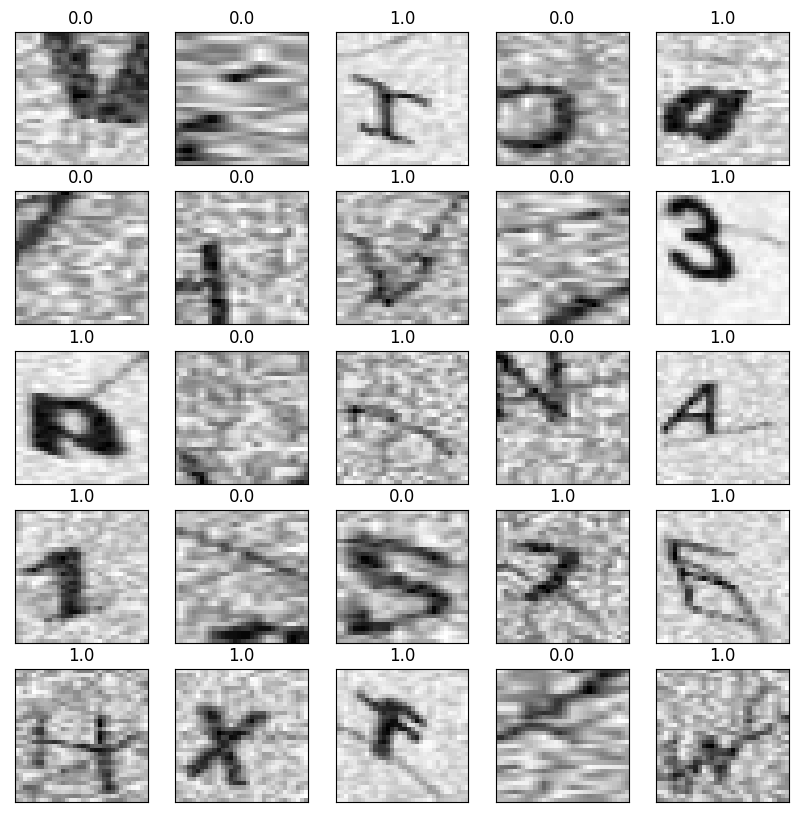

In [6]:
fig, axs = plt.subplots(5,5)
N = x.shape[0]
fig.set_size_inches(10,10)
for i in range(5):
    for j in range(5):
        ax = axs[i,j]
        idx = np.random.randint(N)
        ax.imshow((x[idx,:,:]), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(y[idx])
plt.show()

In [7]:
x = np.squeeze(x)
print(x.shape)

(93600, 32, 32)


In [8]:
#We need to have a singlton dim for chans dimention
if(len(x.shape) == 3):
    x = x[:, :, :, None]
print(x.shape)
np.save('data/x_single_preprocessed.npy', x)
np.save('data/y_single_pos_preprocessed.npy', y)
print("Preprocessed data saved to disk")

(93600, 32, 32, 1)
Preprocessed data saved to disk


In [9]:
#Splitting the data in to test and training sets. Going with a 80/20 
#Also getting dev sets for debugging and tuning hyper parameters.

x = np.load('data/x_single_preprocessed.npy')
y = np.load('data/y_single_pos_preprocessed.npy')

N = x.shape[0]

split_idx = int(N * 0.8)
test_split = 3000
x_train = x[:split_idx,:, :, :] 
x_val = x[split_idx:-test_split, :, :, :]
x_test = x[-test_split:, :, :, :]
x_train_dev = x[:3000, :, :, :]
x_val_dev = x[split_idx:split_idx+500, :, :, :]

y_train = y[:split_idx] 
y_val = y[split_idx:-test_split]
y_test = y[-test_split:]
y_train_dev = y[:3000]
y_val_dev = y[split_idx:split_idx+500]

dataset = (x_train, x_val, x_test, x_train_dev, x_val_dev, y_train, y_val, y_test, y_train_dev, y_val_dev)

for datum in dataset:
    print(datum.shape)


(74880, 32, 32, 1)
(15720, 32, 32, 1)
(3000, 32, 32, 1)
(3000, 32, 32, 1)
(500, 32, 32, 1)
(74880,)
(15720,)
(3000,)
(3000,)
(500,)


# CNN Training

Using tensor flow model here. Following this tutorial:https://www.tensorflow.org/tutorials/images/cnn

In [10]:
import tensorflow as tf
from tensorflow.keras import layers, models

In [11]:
segnet = models.Sequential()
#CNN layer
segnet.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,1)))
segnet.add(layers.MaxPooling2D((2, 2)))
segnet.add(layers.Conv2D(64, (3, 3), activation='relu'))
segnet.add(layers.MaxPooling2D((2, 2)))
segnet.add(layers.Conv2D(64, (3, 3), activation='relu'))

#Dense Layer
segnet.add(layers.Flatten())
segnet.add(layers.Dense(64, activation='relu'))
segnet.add(layers.Dense(1)) 

segnet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 1024)              0

In [19]:
#Training Network
segnet.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = segnet.fit(x_train_dev, y_train_dev, epochs=10, 
                    validation_data=(x_val_dev, y_val_dev))


Epoch 1/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0428 - accuracy: 0.9840 - val_loss: 0.0567 - val_accuracy: 0.9700
Epoch 2/10
94/94 [==============================] - 1s 10ms/step - loss: 0.0392 - accuracy: 0.9853 - val_loss: 0.0479 - val_accuracy: 0.9800
Epoch 3/10
94/94 [==============================] - 1s 10ms/step - loss: 0.0275 - accuracy: 0.9893 - val_loss: 0.0795 - val_accuracy: 0.9620
Epoch 4/10
94/94 [==============================] - 1s 10ms/step - loss: 0.0300 - accuracy: 0.9877 - val_loss: 0.1603 - val_accuracy: 0.9560
Epoch 5/10
94/94 [==============================] - 1s 10ms/step - loss: 0.0409 - accuracy: 0.9833 - val_loss: 0.0650 - val_accuracy: 0.9700
Epoch 6/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0267 - accuracy: 0.9893 - val_loss: 0.0531 - val_accuracy: 0.9860
Epoch 7/10
94/94 [==============================] - 1s 11ms/step - loss: 0.0185 - accuracy: 0.9930 - val_loss: 0.0686 - val_accuracy: 0.9720
Epoch 8/10
94

94/94 - 0s - loss: 0.0578 - accuracy: 0.9787 - 229ms/epoch - 2ms/step


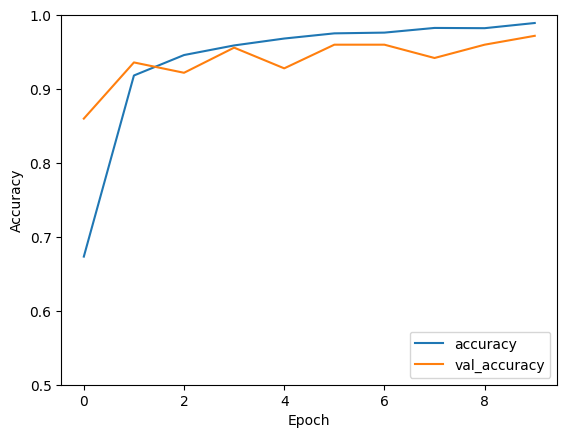

In [7]:
#Plotting Training Data
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
#Printing the test set accuracy
test_loss, test_acc = segnet.evaluate(x_test,  y_test, verbose=2)


In [23]:
#Testing on full size images
#Loading in with imgage_preprocess.py
import image_preprocess
import os

if not os.path.exists("data/x_multi_preprocessed.npy") and not os.path.exists("data/y_multi_preprocessed.npy"):
    print("Preprocessing data...")
    x_multi, y_multi = image_preprocess.preprocess_image_data("data/x_multi.npy", "data/y_multi.npy")
    print("Preprocessed data saved to disk")
else:
    x_multi = np.load("data/x_multi_preprocessed.npy")
    y_multi = np.load("data/y_multi_preprocessed.npy")

print(f"Loaded in images, x.shape = {x_multi.shape}")

Preprocessing data...
Preprocessed data saved to disk
Loaded in images, x.shape = (46800, 72, 200, 1)


In [15]:
#Getting test data
x_multi = x_multi[:1000, :, :]
y_multi = y_multi[:1000]
print(x_multi.shape)
print(y_multi.shape)

(1000, 72, 200, 1)
(1000,)


In [29]:
#Setting up filter function (Taken from CNN Project)
def conv2_gray(img, model, frame=(32,32), verbose=False):
    img_y, img_x, n_chan = img.shape
    ker_x, ker_y = frame

    if verbose:
        print(f'img_x={img_y}, img_y={img_x}')
        print(f'ker_x={ker_x}, ker_y={ker_y}')

    if ker_x != ker_y:
        print('Kernels must be square!')
        return

#     #Padding image with zeros
    padding = int(np.ceil((ker_x - 1)/2))
#     img_padded = np.zeros((img_y+(2*padding), img_x+(2*padding), n_chan))
#     img_padded[padding:-padding, padding:-padding, :] = img
#     img_padded_y, img_padded_x, _ = img_padded.shape

#     if verbose:
#         print(f"Padded Image Size: {img_padded.shape}")
    #Output array
    filteredImg = np.zeros((n_kers, img_y, img_x))

    for i in range(padding, img_y-padding):
        for j in range(padding, img_x-padding):
            correction = 0 if ker_x%2 == 0 else 1
            selection = img[None, i-padding:i+padding+correction, j-padding:j+padding+correction, :]
            if verbose and i==padding and j==padding:
                print(f"Frame size: {selection.shape}")
            selection_tf = tf.convert_to_tensor(selection)
            filteredImg[:, i-padding, j-padding] = model.predict(selection)

    return filteredImg

test = conv2_gray(x_multi[0], segnet, verbose=True)

img_x=32, img_y=32
ker_x=32, ker_y=32


NameError: name 'n_kers' is not defined